In [67]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [68]:
#Import the data
df=pd.read_csv("datasets/cleandf.csv")

In [69]:
pd.set_option('display.max_columns', None)

## LOGIT MODEL

Purpose: create a model to check the variables that affect that a flight is recommended or not.

In [70]:
#Check correlation between variables

In [71]:
df.sample()

,Unnamed: 0,AIRLINENAME,CABINTYPE,DATEFLOWN,DATEPUB,ENTERTAINMENTRATING,FOODRATING,GROUNDSERVICERATING,ORIGINCOUNTRY,OVERALLSCORE,RECOMMENDED,REVIEW,ROUTE,ORIGIN,DESTINY,SCALE_YN,SEATCOMFORTRATING,SERVICERATING,SLUG,TITLE,TRAVELLER,PURPOSE,TRIPVERIFIED,VALUERATING,WIFIRATING,UNIQUE_ID,LONGDISTANCE,YEAR
25820,25923,Egyptair,1,2018-07-01,3rd August 2018,1,1,3,UnitedArabEmirates,5,1,"Dubai to Cairo return, price was very competit...",Dubai to Cairo,Dubai,Cairo,0,1,4,egyptair,a satisfactory flight,3,1,1,3,0,41706636-ce21-4434-baf7-7056337672d6,1,2018


In [72]:
from scipy.stats import chi2_contingency
data_crosstab = pd.crosstab(df['RECOMMENDED'], df['PURPOSE'], margins = False)
data_crosstab 
chi2_contingency(data_crosstab, correction=False)

#most variables are correlated to the Y, except purpose. So no need to transform it to dummy for now.

#STEPS
# Take purpose out from the analysis
# include one or some variables of the rating, as they are quite explanatory of the Y.
# Important: as there is quite correlation, check the possibility to do a KNN/random forest to avoid correlation.

Chi2ContingencyResult(statistic=0.39703197750042224, pvalue=0.5286260617237146, dof=1, expected_freq=array([[ 9198.49151187, 49969.50848813],
       [ 4794.50848813, 26045.49151187]]))

In [73]:
df.sample()

,Unnamed: 0,AIRLINENAME,CABINTYPE,DATEFLOWN,DATEPUB,ENTERTAINMENTRATING,FOODRATING,GROUNDSERVICERATING,ORIGINCOUNTRY,OVERALLSCORE,RECOMMENDED,REVIEW,ROUTE,ORIGIN,DESTINY,SCALE_YN,SEATCOMFORTRATING,SERVICERATING,SLUG,TITLE,TRAVELLER,PURPOSE,TRIPVERIFIED,VALUERATING,WIFIRATING,UNIQUE_ID,LONGDISTANCE,YEAR
12017,12062,Alaska Airlines,4,2019-01-01,14th January 2019,4,4,4,Israel,8,1,New York to San Francisco. Very nice and same ...,New York to San Francisco,New York,San Francisco,0,4,5,alaska-airlines,overall very good flight,1,0,1,4,5,32122a4a-8214-4767-855b-41696b7a673e,1,2019


In [74]:
df.columns

Index(['Unnamed: 0', 'AIRLINENAME', 'CABINTYPE', 'DATEFLOWN', 'DATEPUB',
       'ENTERTAINMENTRATING', 'FOODRATING', 'GROUNDSERVICERATING',
       'ORIGINCOUNTRY', 'OVERALLSCORE', 'RECOMMENDED', 'REVIEW', 'ROUTE',
       'ORIGIN', 'DESTINY', 'SCALE_YN', 'SEATCOMFORTRATING', 'SERVICERATING',
       'SLUG', 'TITLE', 'TRAVELLER', 'PURPOSE', 'TRIPVERIFIED', 'VALUERATING',
       'WIFIRATING', 'UNIQUE_ID', 'LONGDISTANCE', 'YEAR'],
      dtype='object')

In [75]:
df.CABINTYPE.value_counts()

CABINTYPE
1    74608
3    10447
2     3348
4     1605
Name: count, dtype: int64

In [76]:
df.CABINTYPE.value_counts()

CABINTYPE
1    74608
3    10447
2     3348
4     1605
Name: count, dtype: int64

In [77]:
df.TRAVELLER.value_counts()

TRAVELLER
1    46802
2    23538
3    19668
Name: count, dtype: int64

In [78]:
df.LONGDISTANCE.value_counts()

LONGDISTANCE
1    50174
0    39834
Name: count, dtype: int64

In [79]:
df.YEAR.value_counts()

YEAR
2019    15199
2018    14040
2022    12142
2016    11847
2017    11481
2015     9734
2021     6329
2020     5529
2023     3557
2014      147
2013        2
2012        1
Name: count, dtype: int64

In [80]:
checkmodel=df[["CABINTYPE", "TRAVELLER", "GROUNDSERVICERATING", "SEATCOMFORTRATING", "LONGDISTANCE", "SERVICERATING", "SCALE_YN", "TRIPVERIFIED","RECOMMENDED", "YEAR"]]

<Axes: >

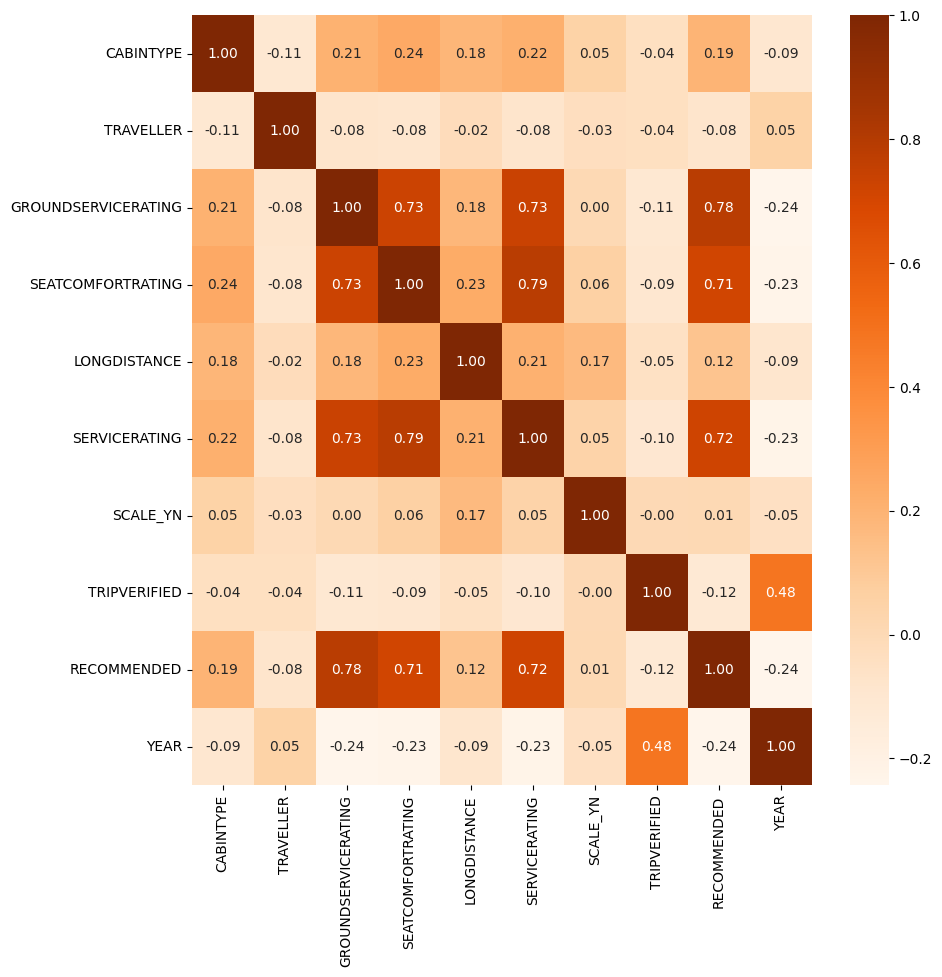

In [81]:
#Check correlation (I know they are categorical, but just to take a look)
correlation_matrix=checkmodel.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap="Oranges", fmt=".2f") 

#some ratings feel quite correlated so let's try VIF

In [82]:
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables=checkmodel.copy()
vif_data=pd.DataFrame()
vif_data["Variable"]=variables.columns
vif_data["VIF"]=[variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
print(vif_data) #quite correlated the whole data

              Variable        VIF
0            CABINTYPE   4.534064
1            TRAVELLER   5.572171
2  GROUNDSERVICERATING   9.954243
3    SEATCOMFORTRATING  11.177364
4         LONGDISTANCE   2.528542
5        SERVICERATING  11.099025
6             SCALE_YN   1.404542
7         TRIPVERIFIED   2.053877
8          RECOMMENDED   4.730065
9                 YEAR  14.766493


In [83]:
#avoid correlation by taking out some ratings. Ground service and seat comfort rating quite correlated to service rating. 
checkmodel.drop(columns="SEATCOMFORTRATING", inplace=True)
checkmodel.drop(columns="GROUNDSERVICERATING", inplace=True)

<Axes: >

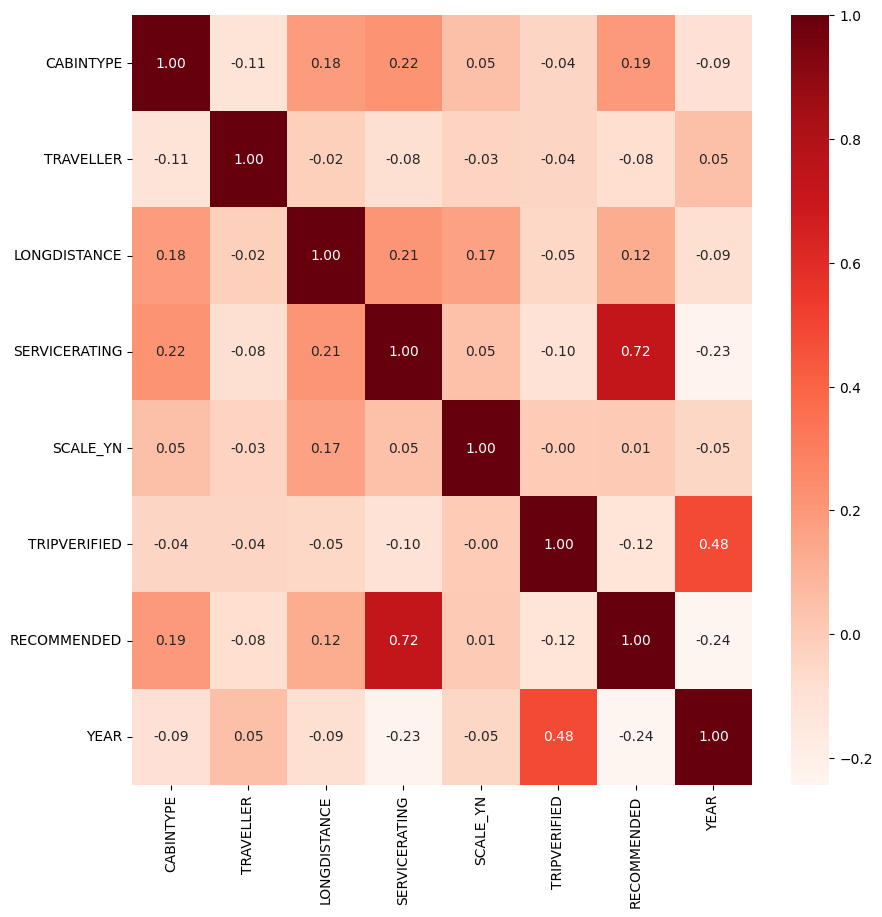

In [84]:
#plot again
correlation_matrix=checkmodel.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap="Reds", fmt=".2f") #fmt es para definir el número de decimales

#ok to have 0.72 with dependant variable (explains it)

In [85]:
#VIF
variables=checkmodel.copy()
vif_data=pd.DataFrame()
vif_data["Variable"]=variables.columns
vif_data["VIF"]=[variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
print(vif_data) #YEAR still quite correlated

        Variable        VIF
0      CABINTYPE   4.495916
1      TRAVELLER   5.571031
2   LONGDISTANCE   2.488124
3  SERVICERATING   7.563530
4       SCALE_YN   1.399907
5   TRIPVERIFIED   2.053195
6    RECOMMENDED   3.230113
7           YEAR  13.914204


In [86]:
checkmodel.drop(columns="YEAR", inplace=True)

In [87]:
#VIF
variables=checkmodel.copy()
vif_data=pd.DataFrame()
vif_data["Variable"]=variables.columns
vif_data["VIF"]=[variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
print(vif_data) #ok now

        Variable       VIF
0      CABINTYPE  3.633224
1      TRAVELLER  3.160361
2   LONGDISTANCE  2.443377
3  SERVICERATING  6.652955
4       SCALE_YN  1.382880
5   TRIPVERIFIED  1.800915
6    RECOMMENDED  3.176365


In [88]:
## LOGIT MODEL NOW

In [89]:
dep=checkmodel[["RECOMMENDED"]] #dependant variable in the model
explicat=df[["CABINTYPE", "TRAVELLER", "SERVICERATING", "SCALE_YN", "LONGDISTANCE", "TRIPVERIFIED"]]#explicative vars


#purpose was not included as it was not correlated to the Y variable --> no effect
#from ratings included those I considered service rating as correlated to the Y, not excessively

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [91]:
X_train, X_test, y_train, y_test= train_test_split(explicat,dep, test_size=0.8, random_state=42)

In [92]:
model=LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [93]:
model.score(X_test, y_test) #quite good

0.8740816865027011

In [94]:
model.score(X_train, y_train) #not overfitting! 

0.8741181045497473

In [95]:
from sklearn.metrics import confusion_matrix 
y_predicted=model.predict(X_test)
confusion_matrix(y_test, y_predicted)

array([[42034,  5343],
       [ 3724, 20906]], dtype=int64)

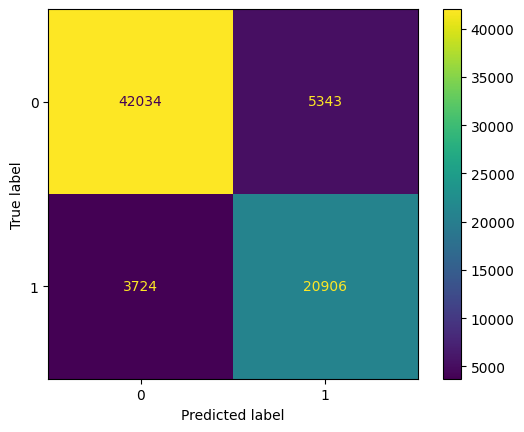

In [96]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_test, y_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [97]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90     47377
           1       0.80      0.85      0.82     24630

    accuracy                           0.87     72007
   macro avg       0.86      0.87      0.86     72007
weighted avg       0.88      0.87      0.87     72007



In [98]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


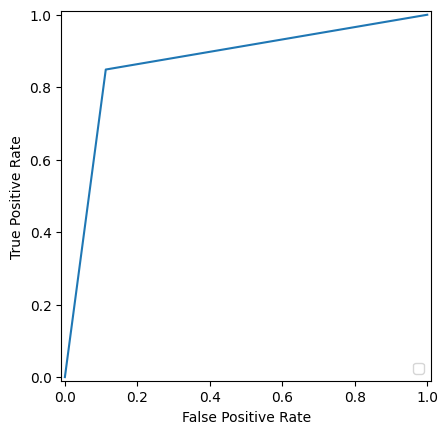

In [99]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted) 
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


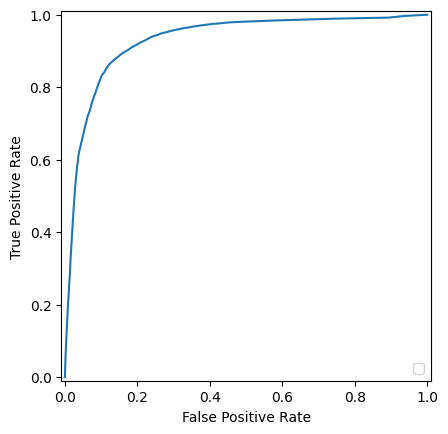

In [100]:
#to have a more curved-shape
y_pred_proba = model.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()

In [101]:
dep.value_counts() #dependant variable (recommended) quite imbalance --> UPSAMPLING (SMOTE method)

RECOMMENDED
0              59168
1              30840
Name: count, dtype: int64

In [102]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [103]:
y = dep
X = explicat
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

RECOMMENDED
0              59168
1              59168
Name: count, dtype: int64

In [104]:
X_sm

,CABINTYPE,TRAVELLER,SERVICERATING,SCALE_YN,LONGDISTANCE,TRIPVERIFIED
0,1,1,5,0,0,1
1,1,1,2,0,0,1
2,1,1,1,0,0,1
3,1,1,3,0,0,1
4,1,1,4,0,0,1
...,...,...,...,...,...,...
118331,2,2,4,0,1,0
118332,3,3,4,0,1,0
118333,1,1,5,0,1,0
118334,3,1,5,0,0,1


In [105]:
x_train, X_test, y_train, y_test=train_test_split(X_sm,y_sm, test_size=0.2, stratify=y_sm, random_state=42)

In [106]:
model=LogisticRegression(random_state=42)
model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [107]:
model.score(X_test, y_test) 

0.875105627851952

In [108]:
from sklearn.metrics import confusion_matrix 
y_predicted=model.predict(X_test)
confusion_matrix(y_test, y_predicted)

array([[10331,  1503],
       [ 1453, 10381]], dtype=int64)

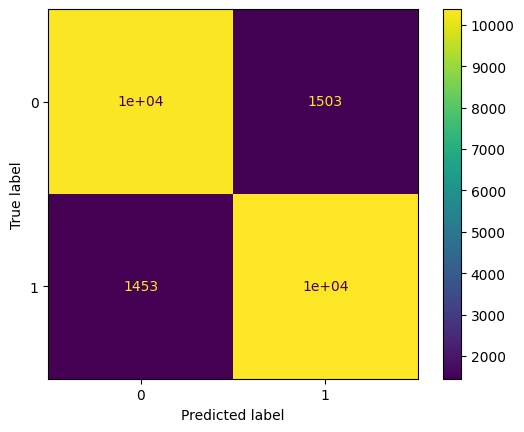

In [109]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_test, y_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [110]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     11834
           1       0.87      0.88      0.88     11834

    accuracy                           0.88     23668
   macro avg       0.88      0.88      0.88     23668
weighted avg       0.88      0.88      0.88     23668



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


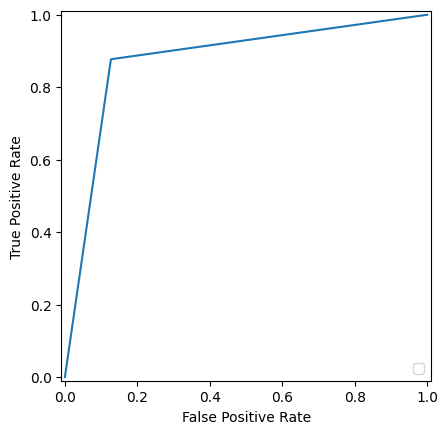

In [111]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted) 
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


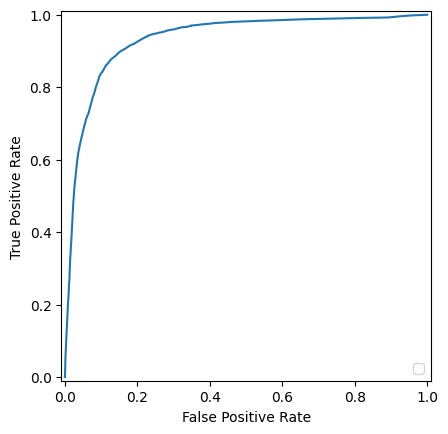

In [112]:
y_pred_proba = model.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()

In [113]:
model.coef_

array([[ 0.18047449, -0.14982333,  1.46315969, -0.21889639, -0.0306907 ,
        -0.4822765 ]])

In [114]:
coeficients=model.coef_.tolist()[0]


In [115]:
names=model.feature_names_in_.tolist()

In [116]:
pd.DataFrame({"Names": names,
             "Coefficients": coeficients})


#A trip verified makes the flight less recommended. Also the fact that there is a scale and long distance flights...and if people travel not alone
#Conversely, highest class and more rating of cabin service positively influde in the recommendation.
#makes sense!

,Names,Coefficients
0,CABINTYPE,0.180474
1,TRAVELLER,-0.149823
2,SERVICERATING,1.463160
3,SCALE_YN,-0.218896
4,LONGDISTANCE,-0.030691
5,TRIPVERIFIED,-0.482276


In [117]:
#there is multicollinearity in Xs. Logit not good. So try a model that does not be influded by multicollinearity: KNN or Random Forest.

## KNN CLASSIFIER

Purpose: check the factors that predict whether a flight is recommended or not (avoiding multicollinearity)

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [119]:
y_sm

,RECOMMENDED
0,1
1,0
2,0
3,0
4,1
...,...
118331,1
118332,1
118333,1
118334,1


In [120]:
#in knn essential to standarise in order to have same metrics therefore same distance between the values!
X_scaled = StandardScaler().fit_transform(X_sm)

# Now, all features will have the same weight.
pd.DataFrame(X_scaled).head()

,0,1,2,3,4,5
0,-0.468705,-0.845084,1.098212,-0.598994,-1.168825,1.033588
1,-0.468705,-0.845084,-0.637771,-0.598994,-1.168825,1.033588
2,-0.468705,-0.845084,-1.216433,-0.598994,-1.168825,1.033588
3,-0.468705,-0.845084,-0.059110,-0.598994,-1.168825,1.033588
4,-0.468705,-0.845084,0.519551,-0.598994,-1.168825,1.033588


In [121]:
X_standarised = pd.DataFrame(X_scaled, columns = X_sm.columns)

In [122]:
X_standarised.head()

,CABINTYPE,TRAVELLER,SERVICERATING,SCALE_YN,LONGDISTANCE,TRIPVERIFIED
0,-0.468705,-0.845084,1.098212,-0.598994,-1.168825,1.033588
1,-0.468705,-0.845084,-0.637771,-0.598994,-1.168825,1.033588
2,-0.468705,-0.845084,-1.216433,-0.598994,-1.168825,1.033588
3,-0.468705,-0.845084,-0.059110,-0.598994,-1.168825,1.033588
4,-0.468705,-0.845084,0.519551,-0.598994,-1.168825,1.033588


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_standarised, y_sm, test_size=0.2, stratify=y_sm, random_state=42)

# Initialize and train the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # Using 5 neighbors
knn_model.fit(X_train, y_train)

# Evaluate the model
accuracy = knn_model.score(X_test, y_test)
print("Accuracy of KNN classifier:", accuracy)

Accuracy of KNN classifier: 0.8677961804968735


In [124]:
from sklearn.metrics import confusion_matrix 
y_predicted=knn_model.predict(X_test)
confusion_matrix(y_test, y_predicted)

array([[10073,  1761],
       [ 1368, 10466]], dtype=int64)

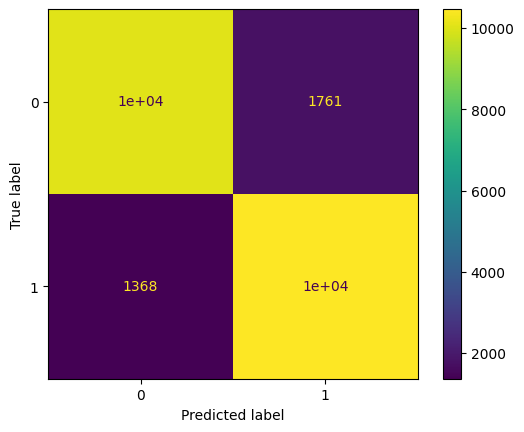

In [125]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_test, y_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [126]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     11834
           1       0.86      0.88      0.87     11834

    accuracy                           0.87     23668
   macro avg       0.87      0.87      0.87     23668
weighted avg       0.87      0.87      0.87     23668



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


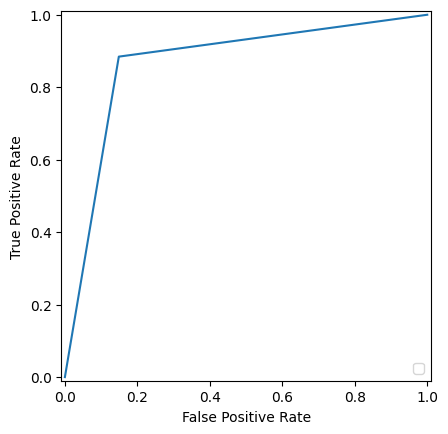

In [127]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted) 
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


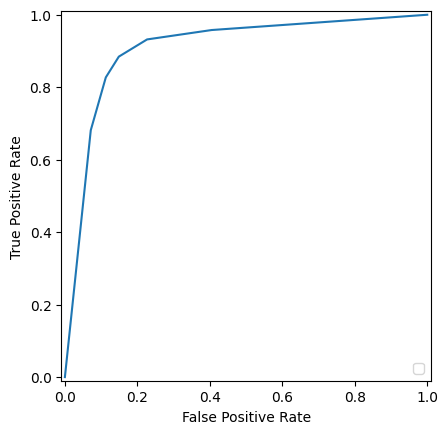

In [128]:
y_pred_proba = knn_model.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show() #ok

In [129]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X_train, y_train, cv=15) #ok, similar scores

array([0.875     , 0.875     , 0.87183143, 0.87244494, 0.8664237 ,
       0.87307875, 0.86769133, 0.87101886, 0.86895896, 0.8661068 ,
       0.86943432, 0.87260339, 0.86468072, 0.86943432, 0.86547298])

In [130]:
from sklearn.model_selection import GridSearchCV

# Define the parameters to test
parameters = {
    'n_neighbors' : range(1, 40),
    'weights': ['uniform', 'distance']
}

# Create grid search instance
grid_search = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           return_train_score = True)

In [131]:
# Fit the grid_search model on training data
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 40),
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [132]:
grid_search.best_params_ 

{'n_neighbors': 36, 'weights': 'uniform'}

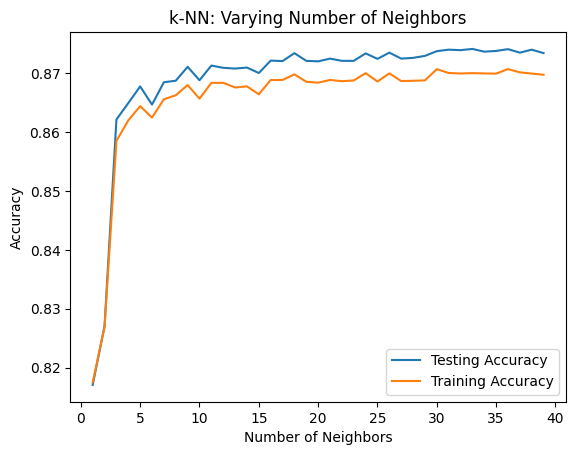

In [133]:
#Let's check the accuracy using different number of neighbors
no_neighbors = np.arange(1, 40)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_train,y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Graph of k values vs accuracy

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [142]:

knn_model = KNeighborsClassifier(n_neighbors=36, weights="uniform")  # Using params from GridSearch
knn_model.fit(X_train, y_train)

# Evaluate the model
accuracy = knn_model.score(X_test, y_test)
print("Accuracy of KNN classifier:", accuracy)

#best result!!

Accuracy of KNN classifier: 0.8741338516139936


In [143]:
#SAVE MODEL OUTPUT
import pickle 
  
# Save the trained model. 
saved_model = pickle.dumps(knn_model) 

In [144]:
# Load the model 
knn_from_pickle = pickle.loads(saved_model) 

In [145]:
knn_from_pickle

KNeighborsClassifier(n_neighbors=36)

In [146]:
from sklearn.metrics import confusion_matrix 
y_predicted=knn_model.predict(X_test)
confusion_matrix(y_test, y_predicted)

array([[10450,  1384],
       [ 1595, 10239]], dtype=int64)

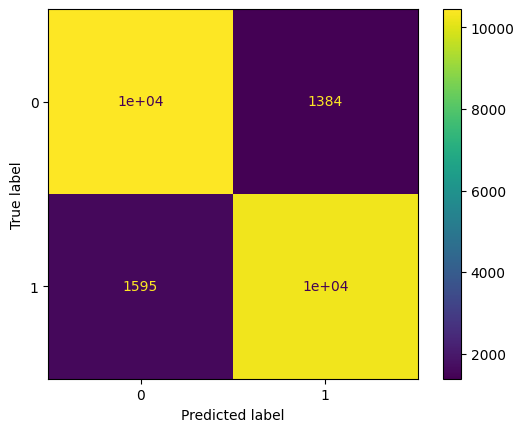

In [147]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_test, y_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [148]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11834
           1       0.88      0.87      0.87     11834

    accuracy                           0.87     23668
   macro avg       0.87      0.87      0.87     23668
weighted avg       0.87      0.87      0.87     23668



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


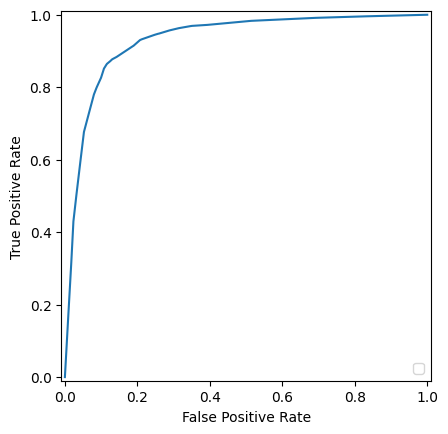

In [149]:
y_pred_proba = knn_model.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()